# Notebook 09: Interpretation of a trained ML model

### Goal: Show some examples of how to interogate a trained ML model

#### Background

While alot of this tutorial has been working up to training and evaluating a ML model they can still seem a bit like a black box. In order to help unvail some things that the ML model has learned, we will do a few *explination* methods on the ML here. Specifically, we will show an example of *permuation importance* and the *accumulated local effects*. Both of these methods were discussed in the paper and are already coded up for you in the ```scikit-explain``` python package maintained by Dr. Flora at CIWRO [link](https://github.com/monte-flora/scikit-explain). These methods will help us understand what the ML learning has learned and give us some clues to the decision proccess it uses.

In order to save some time in setting up python, I did not include this package in the original install. So to install if please activate your ```waf_tutorial_part1``` enviornment

```$ conda activate waf_tutorial_part1 ``` 

then pip install the ```scikit-explain```

```$ pip install scikit-explain``` 

If when importing the next cell you get an error with importing matplotlib (something about a multiindex), upgrade matplotlib 

```$ pip install -U matplotlib``` 

#### Load presaved model + Training Data 

In notebook 4 and 5, we showed you how to save/load the simple ML model. Feel free to change the path to that file if you wish to see your model results. If not, leave the file path as is to see the trained models in the paper (without SVM because there is no ```predict_proba``` method, which is needed).

Just like the paper, we will start with the classification models. We also need the training data to do the investigations, so lets load that in too

In [1]:
###################################### Load trained models ######################################
import joblib
names = ['LogisticRegression.pkl','NaiveBayes.pkl','DecisionTree.pkl','RandomForest.pkl','GradientBoostedTrees.pkl',]
start_path = '../datasets/sklearnmodels/classification/allfeatures/'
model_list = []

for name in names:
    #notice the change from wb to rb 
    savefile = open(start_path + name,'rb')
    #notice the change from dump to load 
    model_list.append(joblib.load(savefile))
    
print(model_list)
################################################################################################

###################################### Load training data ######################################
#import some helper functions for our other directory.
import sys
sys.path.insert(1, '../scripts/')
from aux_functions import load_n_combine_df
import numpy as np
(X_train,y_train),(X_validate,y_validate),_ = load_n_combine_df(path_to_data='../datasets/sevir/',features_to_keep=np.arange(0,36,1),class_labels=True)

#remember since we have all 36 predictors we need to scale the inputs 
from sklearn.preprocessing import StandardScaler
#create scaling object 
scaler = StandardScaler()
#fit scaler to training data
scaler.fit(X_train)
#transform feature data into scaled space 
X_train = scaler.transform(X_train)
X_validate = scaler.transform(X_validate)
################################################################################################


[LogisticRegression(), GaussianNB(), DecisionTreeClassifier(), RandomForestClassifier(), GradientBoostingClassifier()]


We do need to do a small adjustment to our training data. The ```skexplain``` expects a dataframe with the names of each column. So we have gone ahead and provided a list of names for each column in the next cell. The *q* stands for quantile and then the number is the percentile that it is (where 0 is the min and 100 is the max). Then the *_* shows which variable it is (ir=='infrared',wv=='water vapor',vi=='visible',vl=='VIL')

In [2]:
import pandas as pd
column_names = ['q000_ir',
 'q001_ir',
 'q010_ir',
 'q025_ir',
 'q050_ir',
 'q075_ir',
 'q090_ir',
 'q099_ir',
 'q100_ir',
 'q000_wv',
 'q001_wv',
 'q010_wv',
 'q025_wv',
 'q050_wv',
 'q075_wv',
 'q090_wv',
 'q099_wv',
 'q100_wv',
 'q000_vi',
 'q001_vi',
 'q010_vi',
 'q025_vi',
 'q050_vi',
 'q075_vi',
 'q090_vi',
 'q099_vi',
 'q100_vi',
 'q000_vl',
 'q001_vl',
 'q010_vl',
 'q025_vl',
 'q050_vl',
 'q075_vl',
 'q090_vl',
 'q099_vl',
 'q100_vl']

X_df = pd.DataFrame(X_validate,columns=column_names)
X_df.head()

,q000_ir,q001_ir,q010_ir,q025_ir,q050_ir,q075_ir,q090_ir,q099_ir,q100_ir,q000_wv,...,q100_vi,q000_vl,q001_vl,q010_vl,q025_vl,q050_vl,q075_vl,q090_vl,q099_vl,q100_vl
0,0.107446,-0.069976,-0.253568,-0.257330,-0.390479,-0.403563,-0.163391,-0.002153,0.112469,0.372505,...,0.600918,-0.076202,-0.080045,-0.105838,-0.169879,-0.264134,-0.316526,-0.149893,-0.084314,-0.506200
1,-0.013895,0.113248,0.656777,0.519347,0.193368,-0.184280,-0.422277,-0.084017,0.442294,0.114262,...,0.800338,-0.076202,-0.080045,-0.105838,-0.169879,-0.194678,0.126478,0.520698,0.254044,0.299233
2,0.108580,0.049271,0.079059,-0.060190,-0.416348,-0.743419,-0.916883,-0.810590,0.086714,0.337585,...,0.753428,-0.076202,-0.080045,-0.105838,0.087540,0.638789,0.938651,0.717931,0.207904,-0.242885
3,0.445386,0.289766,0.382246,0.386894,0.174635,0.146080,0.292410,0.405605,0.284443,0.694903,...,0.604475,-0.076202,-0.080045,-0.105838,-0.169879,-0.298862,-0.636473,-0.840208,-0.530332,-0.258374
4,0.992554,1.492513,1.658309,1.619017,1.410568,1.114670,0.925436,0.785285,0.808673,0.822401,...,1.068231,-0.076202,-0.080045,-0.105838,-0.169879,-0.368317,-0.661084,-1.057164,-0.699511,0.299233


okay, our data is ready then to use the ```skexplain``` package. Both methods discussed will use the method named ```ExplainToolkit()``` where the inputs are your trained models ```estimators``` and your data ```X```,```y```

In [3]:
import skexplain

estimators = estimators = [('LogisticRegression',model_list[0]),('NaiveBayes',model_list[1]),('DecisionTree',model_list[2]),('RandomForest',model_list[3]),('GradientBoostedTrees',model_list[4])]
explainer = skexplain.ExplainToolkit(estimators=estimators, X=X_df, y=y_validate,)
                                                               

Now that the main explainer object is defined, we will calcualte the permuation importance. 


### Single Pass permuation importance

Here is a good animation of what single pass permuation importance does. Click the image to take you to the page source.

<a href=https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance> <img alt="Animation of singlepass permutation importance" src="https://permutationimportance.readthedocs.io/en/latest/_images/SinglePassPermutation.gif"> </a>


Each predictor (i.e., feature) is shuffled to see how it impacts some sort of metric (i.e., loss/error). For our example we use the AUC of the ROC curve, like we dicussed in the paper. The intuition is that the most important predictor will be the one that *hurts* the model performance the most when it is shuffled (i.e., random). 

### Multipass permutation importance

Unfortunately, there are alot of correlations between input predictors in most datasets. So single pass permuation importance might not show use the true value of some inputs because the prediction power might be split across the highly correlated features. One way around that is to do a mult-pass permutation importance. 

<a href=https://permutationimportance.readthedocs.io/en/latest/methods.html#permutation-importance> <img alt="Animation of multipass permutation importance" src="https://permutationimportance.readthedocs.io/en/latest/_images/MultiPassPermutation.gif"> </a>


So as you can see in the gif, we first permutate all of them (like single pass), find the max change to the loss, then we freeze the shuffled variable that caused the largest change. From there, we shuffle the variables that are left. we repeat this until you get the disired number of variables (above we chose 5). 



Note that it does take a decent amount of time to do this test. So if you can do this in parallel (i.e., how many cores does your machine have?) change ```n_jobs``` to something > 1. 


In [4]:
results = explainer.permutation_importance(n_vars=5,evaluation_fn='auc', n_permute=10, subsample=0.25,n_jobs=1,verbose=True,random_seed=42, 
                                           direction='backward',)

# Save the permutation importance results as a netcdf file using the bulit-in function within mintpy
# explainer.save(fname='multipass_importance_naupdc.nc', data=results)

Multi-pass iteration 1 out of 5...
Multi-pass iteration 2 out of 5...
Multi-pass iteration 3 out of 5...
Multi-pass iteration 4 out of 5...
Multi-pass iteration 5 out of 5...
Multi-pass iteration 1 out of 5...
Multi-pass iteration 2 out of 5...
Multi-pass iteration 3 out of 5...
Multi-pass iteration 4 out of 5...
Multi-pass iteration 5 out of 5...
Multi-pass iteration 1 out of 5...
Multi-pass iteration 2 out of 5...
Multi-pass iteration 3 out of 5...
Multi-pass iteration 4 out of 5...
Multi-pass iteration 5 out of 5...
Multi-pass iteration 1 out of 5...
Multi-pass iteration 2 out of 5...
Multi-pass iteration 3 out of 5...
Multi-pass iteration 4 out of 5...
Multi-pass iteration 5 out of 5...
Multi-pass iteration 1 out of 5...
Multi-pass iteration 2 out of 5...
Multi-pass iteration 3 out of 5...
Multi-pass iteration 4 out of 5...
Multi-pass iteration 5 out of 5...


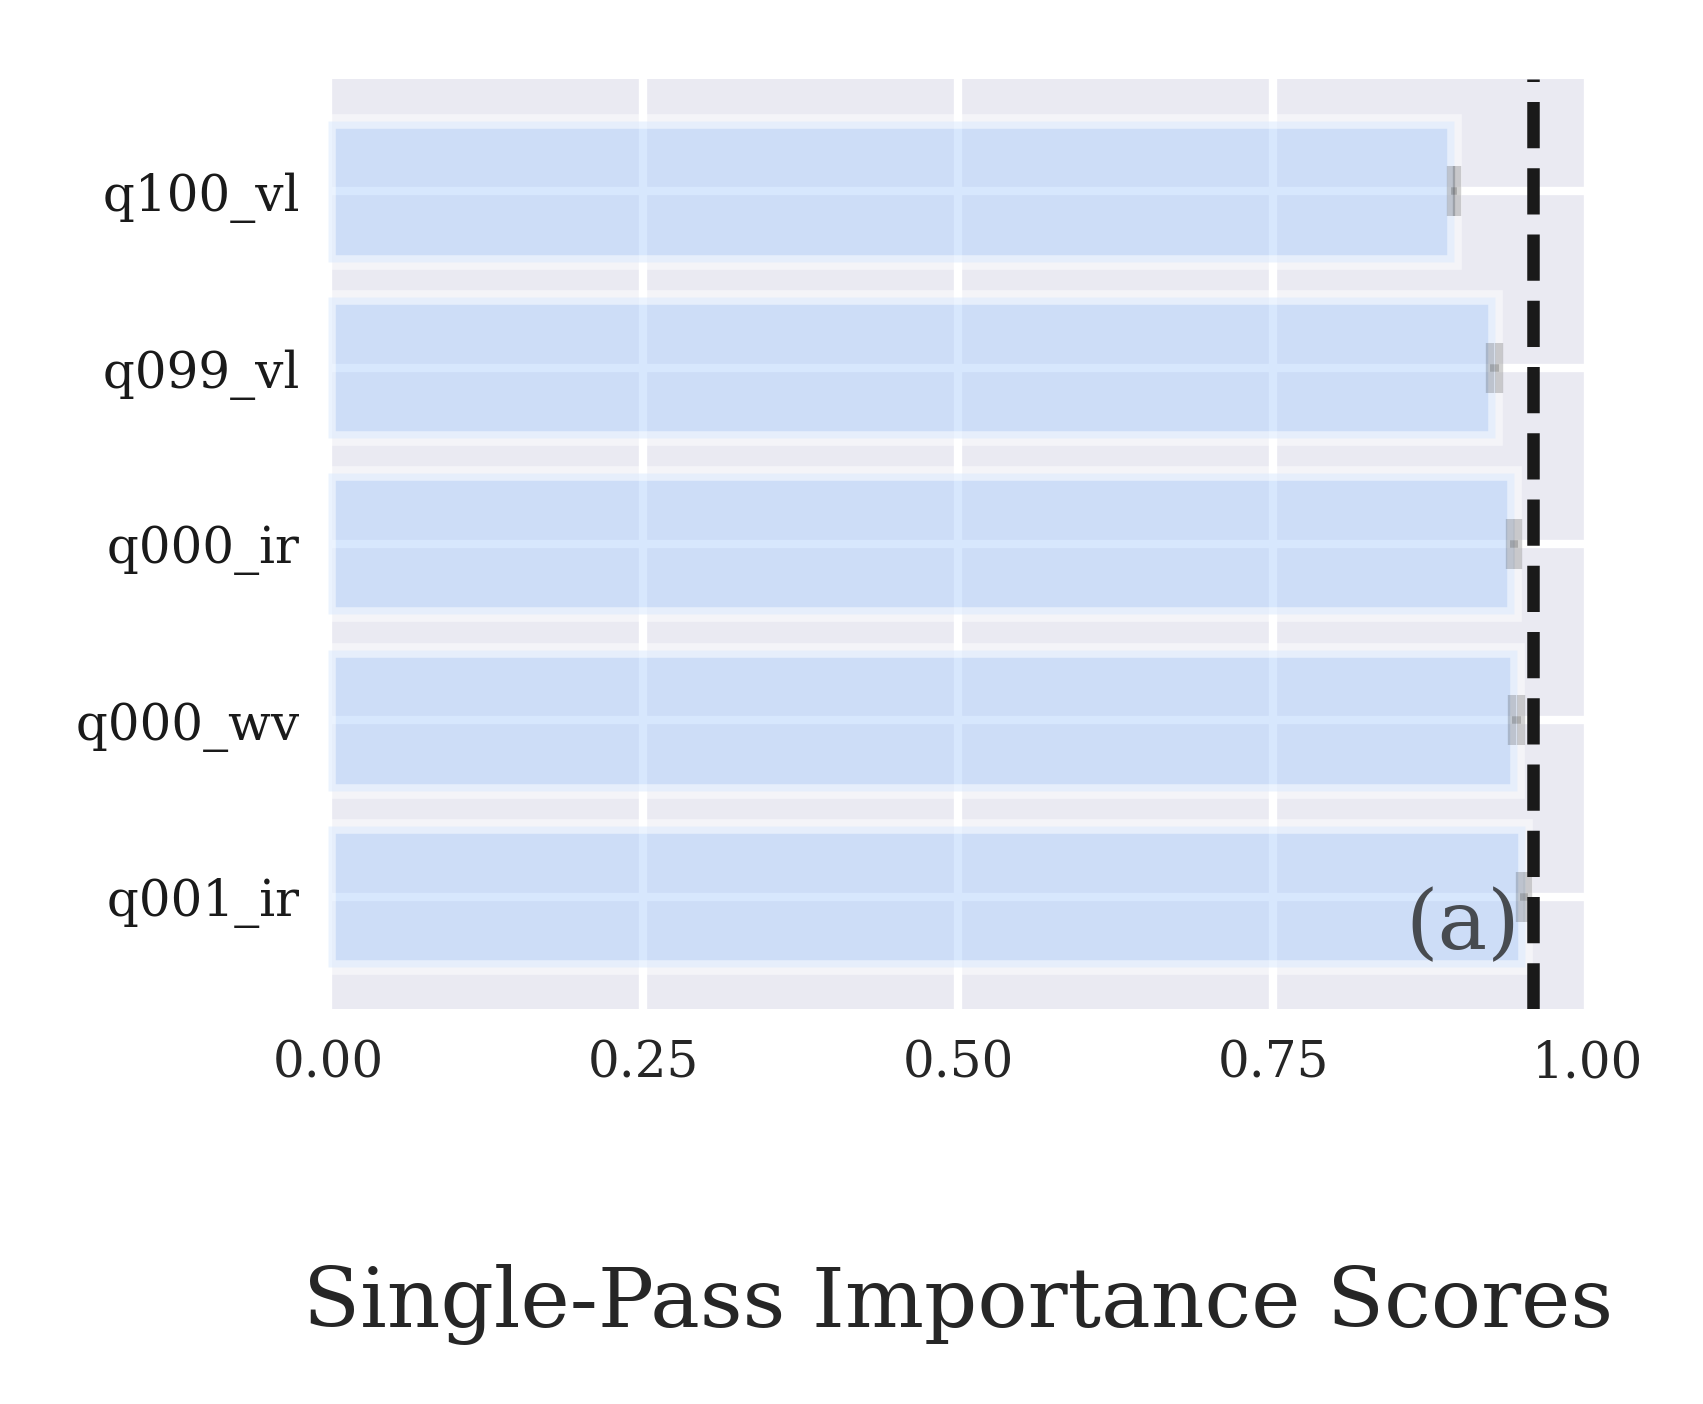

In [7]:
import matplotlib.pyplot as plt

#make default resolution of figures much higher (i.e., High definition)
%config InlineBackend.figure_format = 'retina'

fig = explainer.plot_importance(data=results, 
                                panels=[('singlepass', 'RandomForest')], 
                                num_vars_to_plot=5, 
                                 zorder=1)

ax = plt.gca()
ax.axvline(results.original_score__RandomForest[0],color='k',ls='--',zorder=0)

results

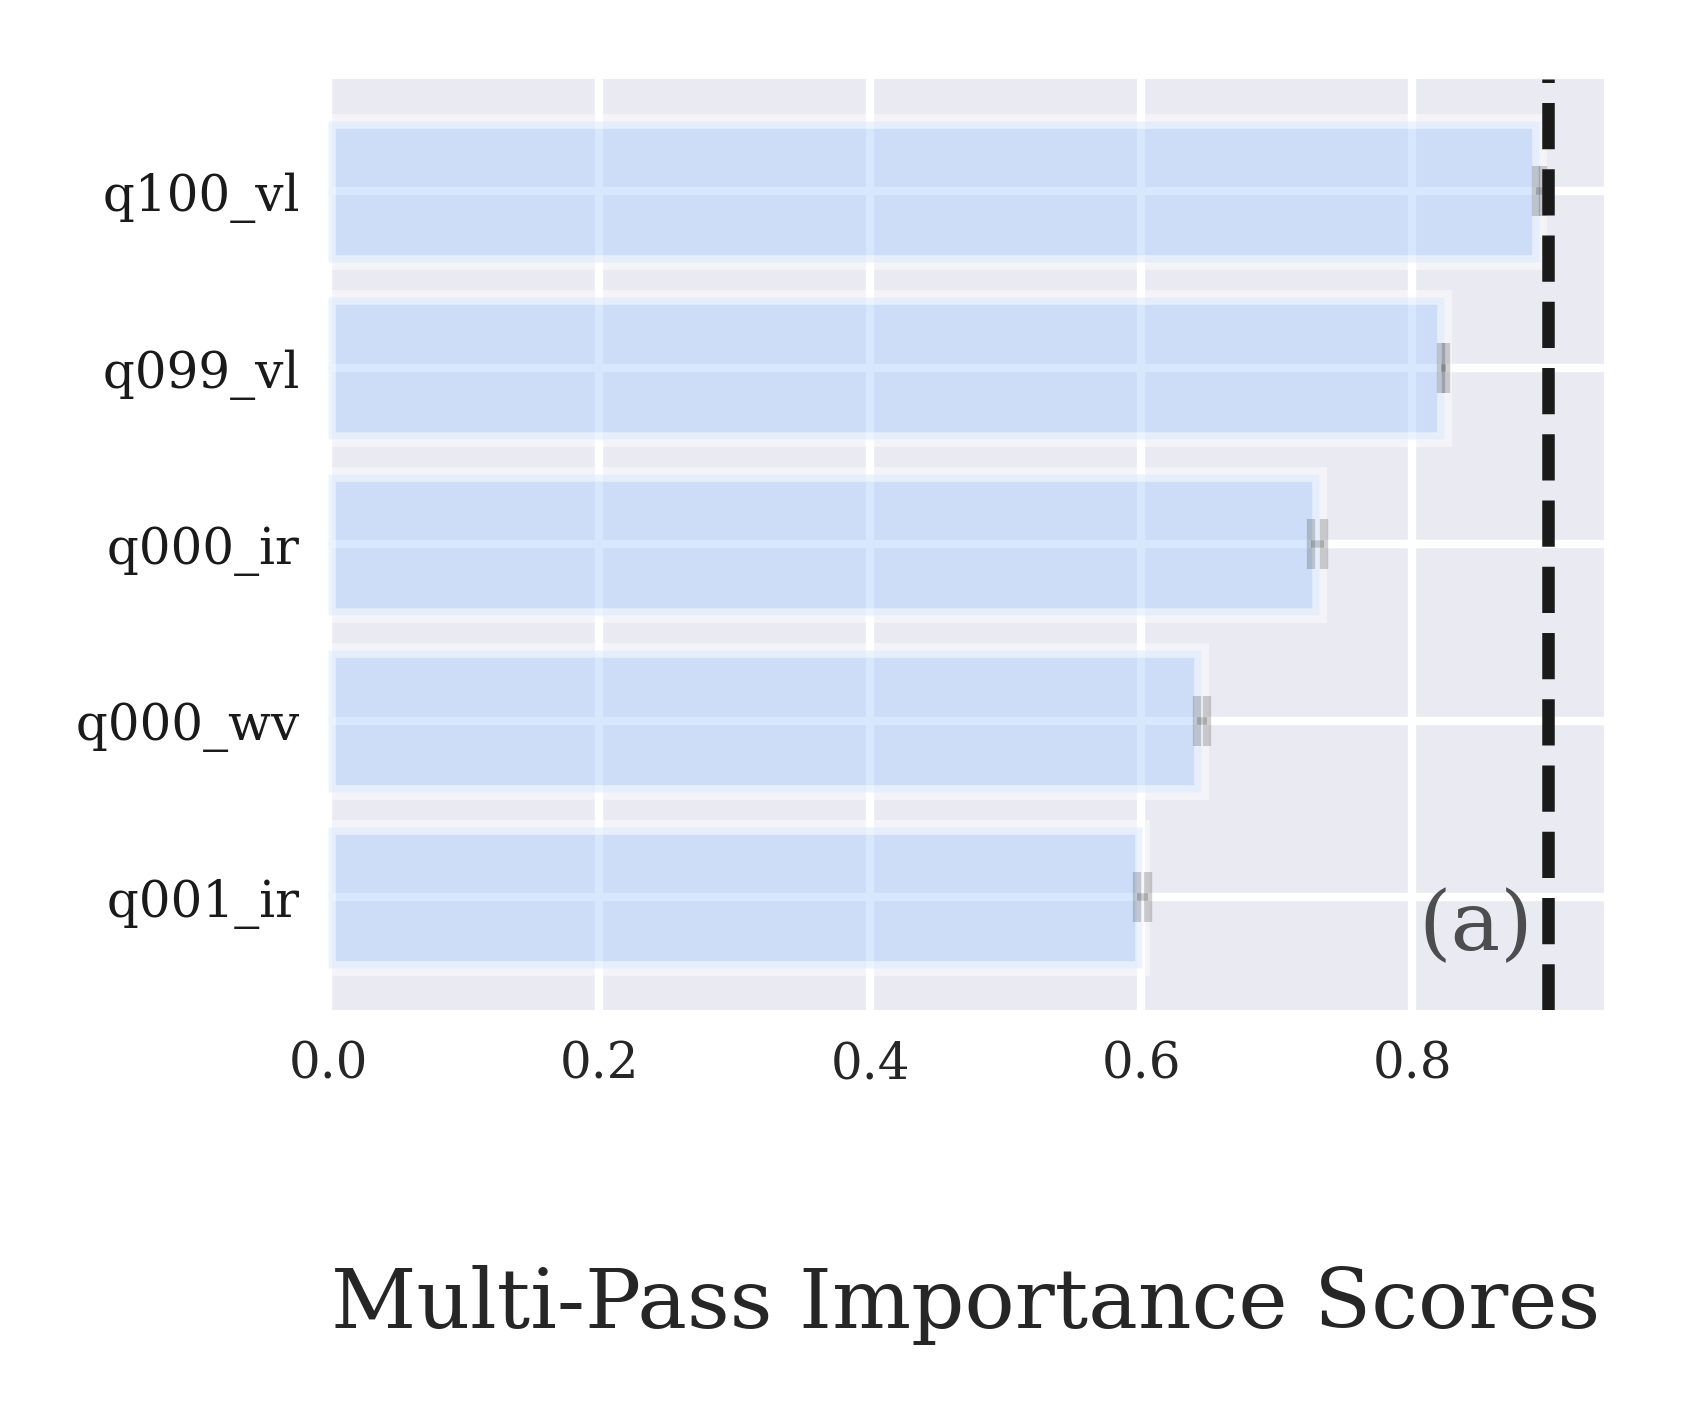

In [9]:


fig = explainer.plot_importance(data=results, 
                                panels=[('multipass', 'RandomForest')], 
                                num_vars_to_plot=5, 
                                 zorder=1)

ax = plt.gca()
ax.axvline(results.original_score__RandomForest[0],color='k',ls='--',zorder=0)